In [1]:
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid, save_image
from einops import rearrange
from PIL import Image
import os 
import imageio
plt.rcParams['figure.figsize'] = [50, 10]
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']


In [2]:
def show(imgs, n_y = 24, n_x=10, dim=64, label=False):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        y = img.shape[1]
        x = img.shape[2]
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        if label:
            border = (x - n_x * dim) / 10
            x_loc = [n * (64 + border) + dim / 2 for n in range(n_x - 2, n_x)]
            y_loc = [n * (64 + border) + dim / 2 for n in range(n_y)]
            y_labels = [fr"$W_{i}$"for i in range(1, len(y_loc))] + ["Diffusion\nProcess",]
            axs[0, i].set(xticklabels=["Generated", "Target"], yticklabels=y_labels, xticks=x_loc, yticks=y_loc)
        else:
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
spoof = False
src_dir = "/scratch/work/spieglb1/view-fusion/logs/2024-01-17T15-13-15-multi-view-composable-variable-small-v100-generate"
generated_batch = torch.load(os.path.join(src_dir, "generated_batch.pt"), map_location=torch.device("cpu"))
logit_arr = torch.load(os.path.join(src_dir, "logit_arr.pt"), map_location=torch.device("cpu"))
weight_arr = torch.load(os.path.join(src_dir, "weight_arr.pt"), map_location=torch.device("cpu"))
target = torch.load(os.path.join(src_dir, "target.pt"), map_location=torch.device("cpu"))
cond = torch.load(os.path.join(src_dir, "cond.pt"), map_location=torch.device("cpu"))
view_count = torch.load(os.path.join(src_dir, "view_count.pt"), map_location=torch.device("cpu"))


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/work/spieglb1/view-fusion/logs/2024-01-17T15-13-15-multi-view-composable-variable-small-v100-generate/generated_batch.pt'

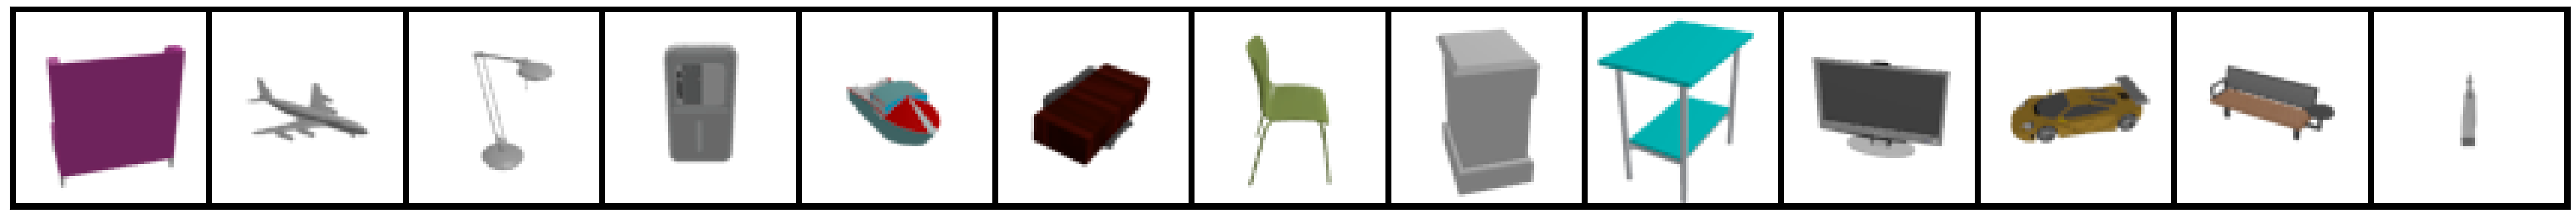

In [17]:
target_grid = make_grid(target, nrow=13)
show(target_grid)

In [4]:
cond_padded = torch.nn.utils.rnn.pad_sequence(
[
    cond[i, :view_idx]
    for i, view_idx in enumerate(view_count)
],
batch_first=True,
padding_value=1.0
)

# print(generated_batch.shape, target.shape, cond.shape, sep="\n")
print(generated_batch.shape)
output = torch.cat(
(
    torch.clamp(generated_batch[:, -1, ...][:, None, ...], 0, 1),
    torch.unsqueeze(target, 1),
    cond_padded,
),
dim=1,
)

padded_output = make_grid(
    rearrange(output, "b s c h w -> (b s) c h w"),
    nrow=output.shape[1],
    scale_each=True,
    pad_value=0.9
)
# save_image(padded_output, "input.png")
show(padded_output)

NameError: name 'view_count' is not defined

In [5]:
i = 5
target_grid = torch.cat([target[i, ...][None, ...],] * (weight_arr.shape[2] + 1))[None, ...]
view_weights = torch.cat((weight_arr[i, ...], cond[i, :weight_arr.shape[2], :3, ...][None, ...]), dim=0)
view_weights = torch.cat((view_weights, torch.clamp(generated_batch[i, ...][:, None, ...], 0, 1)), dim=1)
print(view_weights.shape)
print(target_grid.shape)
view_weights = torch.cat((view_weights, target_grid))
view_weights = make_grid(rearrange(view_weights, "s v c h w -> (v s) c h w"), nrow=view_weights.shape[0], scale_each=True, pad_value=1.0)
save_image(view_weights, "architecture_sample.png")
print(view_weights.shape)
show(view_weights)

NameError: name 'target' is not defined

In [6]:
n = 1
variable_generated_batch = torch.load(os.path.join(src_dir, f"variable_generated_batch_{n}.pt"), map_location=torch.device("cpu"))
variable_logit_arr = torch.load(os.path.join(src_dir, f"variable_logit_arr_{n}.pt"), map_location=torch.device("cpu"))
variable_weight_arr = torch.load(os.path.join(src_dir, f"variable_weight_arr_{n}.pt"), map_location=torch.device("cpu"))
target = torch.load(os.path.join(src_dir, "target.pt"), map_location=torch.device("cpu"))

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/work/spieglb1/view-fusion/logs/2024-01-17T15-13-15-multi-view-composable-variable-small-v100-generate/variable_generated_batch_1.pt'

In [7]:
i = 10
target_grid = torch.cat([target[i, ...][None, ...],] * (variable_weight_arr.shape[2] + 1))[None, ...]
view_weights = torch.cat((variable_weight_arr[i, ...], cond[i, :variable_weight_arr.shape[2], :3, ...][None, ...]), dim=0)
view_weights = torch.cat((view_weights, torch.clamp(variable_generated_batch[i, ...][:, None, ...], 0, 1)), dim=1)
view_weights = torch.cat((view_weights, target_grid))
view_weights = make_grid(rearrange(view_weights, "s v c h w -> (v s) c h w"), nrow=view_weights.shape[0], scale_each=True)
show(view_weights, n_y=variable_weight_arr.shape[2]+1)

NameError: name 'target' is not defined

In [8]:
i = 1
ar_src = "/scratch/work/spieglb1/view-fusion/logs/2024-03-09T18-50-06-small-v100-4-withheld-eval/ar"
generated_samples = torch.clamp(torch.load(os.path.join(ar_src, f"samples_{i}.pt"), map_location=torch.device("cpu")), 0, 1)
all_views = torch.load(os.path.join(ar_src, f"all_views.pt"), map_location=torch.device("cpu"))
targets = make_grid(all_views.squeeze(), nrow=24, scale_each=False)

save_image(targets, "ground_truth_car.png")

In [9]:
sample_list = torch.stack([torch.load(os.path.join(ar_src, f"samples_{i}.pt"), map_location=torch.device("cpu")) for i in range(1, 25)])
all_samples = torch.clamp(sample_list, 0, 1)
samples = make_grid(all_samples.squeeze(), nrow=24, scale_each=False)

save_image(samples, "generated_car.png")

torch.Size([24, 24, 3, 64, 64]) torch.Size([24, 1, 3, 64, 64])
torch.Size([24, 25, 3, 64, 64])


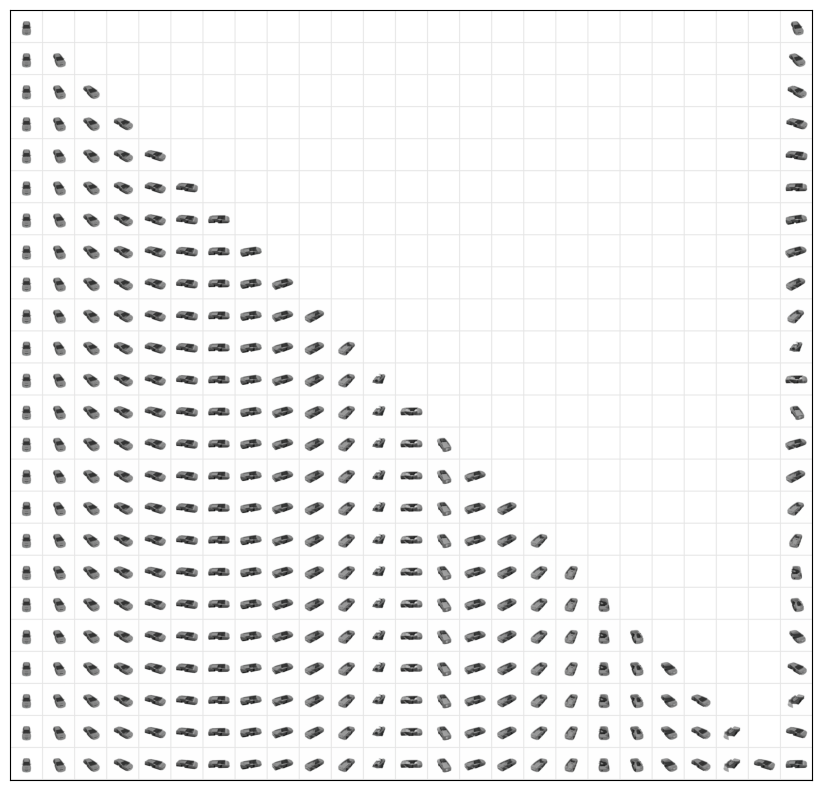

In [10]:
cond_list = [torch.load(os.path.join(ar_src, f"cond_{i}.pt"), map_location=torch.device("cpu"))[0] for i in range(24)]
conds_padded = torch.clamp(torch.nn.utils.rnn.pad_sequence(cond_list, batch_first=True, padding_value=1.0), 0, 1)

sample_list = torch.stack([torch.load(os.path.join(ar_src, f"samples_{i}.pt"), map_location=torch.device("cpu")) for i in range(1, 25)])
all_samples = torch.clamp(sample_list, 0, 1)

print(conds_padded.shape, all_samples.shape)
# cond_grid = make_grid(rearrange(conds_padded, "s v c h w -> (s v) c h w"), nrow=14)
# show(cond_grid)
conds_samples = torch.cat((conds_padded, all_samples), dim=1)
print(conds_samples.shape)
img_rearranged = rearrange(conds_samples, "s v c h w -> (s v) c h w")
img_rearranged.shape
ar_grid = make_grid(img_rearranged, nrow=25, pad_value=0.9)
save_image(ar_grid, "ar_full.png")
show(ar_grid)

In [11]:
all_samples.shape

torch.Size([24, 1, 3, 64, 64])

In [12]:
conds_padded.shape

torch.Size([24, 24, 3, 64, 64])

In [13]:
joint = [torch.cat((cond, sample)) for sample, cond in zip(all_samples, conds_padded)]

torch.Size([3, 68, 1652])


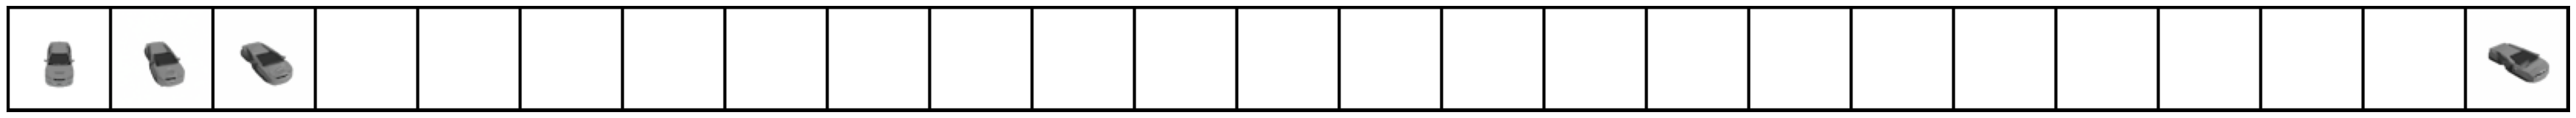

In [18]:
joint_grid = make_grid(joint[2], nrow=25)
print(joint_grid.shape)
show(joint_grid)

In [15]:
frames = [torch.clamp(rearrange(sample.squeeze(), "c h w -> h w c"), 0, 1) for sample in sample_list]
imageio.mimsave(
                os.path.join("/scratch/work/spieglb1/view-fusion", "output.gif"), frames, "GIF", duration=0.1
            )


TypeError: Cannot handle this data type: (1, 1, 3), <f4

In [16]:
sample_frames = [rearrange(make_grid(sample, nrow=25), "c h w -> h w c") for sample in joint]
imageio.mimsave(
                os.path.join("/scratch/work/spieglb1/view-fusion", "output.gif"), sample_frames, "GIF", duration=0.1
            )

TypeError: Cannot handle this data type: (1, 1, 3), <f4

In [103]:
spoof = False
src_dir = "/scratch/work/spieglb1/view-fusion/logs/2024-01-17T15-13-15-multi-view-composable-variable-small-v100-generate"
generated_batch = torch.load(os.path.join(src_dir, "generated_batch_plausible_0.pt"), map_location=torch.device("cpu"))
# logit_arr = torch.load(os.path.join(src_dir, "logit_arr.pt"), map_location=torch.device("cpu"))
# weight_arr = torch.load(os.path.join(src_dir, "weight_arr.pt"), map_location=torch.device("cpu"))
target = torch.load(os.path.join(src_dir, "target_plausible.pt"), map_location=torch.device("cpu"))
cond = torch.load(os.path.join(src_dir, "cond_plausible.pt"), map_location=torch.device("cpu"))
# view_count = torch.load(os.path.join(src_dir, "view_count.pt"), map_location=torch.device("cpu"))

torch.Size([13, 9, 3, 64, 64])
torch.Size([13, 1, 3, 64, 64])


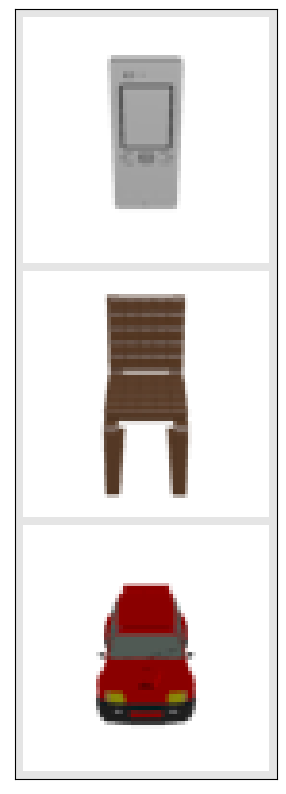

In [105]:
cond_padded = torch.nn.utils.rnn.pad_sequence(
[
    cond[i, :view_idx]
    for i, view_idx in enumerate(view_count)
],
batch_first=True,
padding_value=1.0
)

# print(generated_batch.shape, target.shape, cond.shape, sep="\n")
print(generated_batch.shape)
indices = torch.as_tensor((3, 6, 10))
print(target.shape)
output = torch.cat(
(
    # torch.index_select(torch.clamp(generated_batch[:, -1, ...][:, None, ...], 0, 1), 0, indices),
    # torch.unsqueeze(target, 1),
    # torch.index_select(target, 0, indices),
    torch.index_select(cond_padded, 0, indices),
),
dim=1,
)
# output = torch.cat(
# (
#     torch.clamp(generated_batch[:, -1, ...][:, None, ...], 0, 1),
#     # torch.unsqueeze(target, 1),
#     target,
#     cond_padded,
# ),
# dim=1,
# )

padded_output = make_grid(
    rearrange(output, "b s c h w -> (b s) c h w"),
    nrow=output.shape[1],
    scale_each=True,
    pad_value=0.9
)
save_image(padded_output, "input_plausible.png")
show(padded_output)